/var/folders/bp/qbk6vrmx3vz8pnjkwdvk9_b40000gn/T/ipykernel_58097/146649834.py:235: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


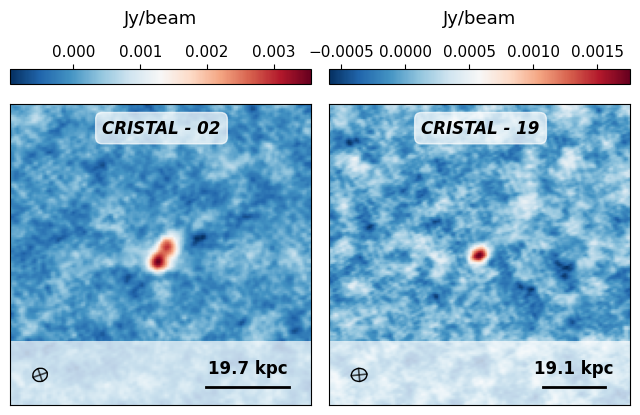

In [ ]:
from functions import *
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel  
from spectral_cube import SpectralCube
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy import units as u
import matplotlib.patches as patches
from astropy.cosmology import Planck18

fname = '/Users/arnablahiry/Work/data/new_cubes/Cristal_02_TM1_TM2_ALPINE_ALL_Contsub_CubeCII_Natural_10kms_image.fits'
fname2 = '/Users/arnablahiry/Work/data/new_cubes/Cristal_19_TM1_TM2_ALPINE_Contsub_CubeCII_Natural_10kms_image.fits'
fname3 = '/Users/arnablahiry/Work/data/new_cubes/Cristal_10_TM1_TM2_ALPINE_Contsub_CubeCII_Natural_10kms_image.fits'
fname4 = '/Users/arnablahiry/Work/data/new_cubes/CRISTAL_21_HZ7_Contsub_CubeCII_Natural_10kms_image.fits'




# --- Load the cube ---
cube = SpectralCube.read(fname, format='fits')

# Define pixel slices (example: crop spatial axes only)
# Suppose cube shape is (velocity, y, x)
# Crop y from 200 to 400, x from 200 to 400, keep all velocity channels
#slices = (slice(None), slice(50, -50), slice(50, -50))

# Crop the cube spatially
# Suppose you want to crop x pixels from 200 to 400, y pixels 200 to 400
cropped_cube = cube.subcube(xlo=130, xhi=np.shape(cube)[2]-130, ylo=130, yhi=np.shape(cube)[1]-130)

# --- Cosmology ---
z = 5.3
kpc_per_arcsec = Planck18.kpc_proper_per_arcmin(z).to('kpc/arcsec').value

# --- Pixel scale ---
pixscale_deg = abs(cropped_cube.header['CDELT1'])             # deg/pixel
pixscale_arcsec = pixscale_deg * 3600            # arcsec/pixel
pixscale_kpc = pixscale_arcsec * kpc_per_arcsec  # kpc/pixel


data = cropped_cube.unmasked_data[:].value
data = data.astype(data.dtype.newbyteorder('='))
data[np.isnan(data)] = 0.0

max_voxel_index = np.argmax(data)
max_channel, max_y, max_x = np.unravel_index(max_voxel_index, data.shape)



import numpy as np
from astropy.wcs.utils import proj_plane_pixel_scales



# Get pixel scale in arcsec/pixel for spatial axes
pixscale_y, pixscale_x = proj_plane_pixel_scales(cropped_cube.wcs.celestial) * 3600.0  # arcsec/pixel


# Extract beam properties
bmaj_pix = np.array([b.major.to('arcsec').value / pixscale_x for b in cropped_cube.beams])
bmin_pix = np.array([b.minor.to('arcsec').value / pixscale_y for b in cropped_cube.beams])
bpa_deg  = np.array([b.pa.to('deg').value for b in cropped_cube.beams])

# Combine into a (144, 3) array
beam_array = np.column_stack((bmaj_pix, bmin_pix, bpa_deg))

beam_area_pix2 = (np.pi / (4 * np.log(2))) * bmaj_pix * bmin_pix  # shape: (num_channels,)
beam = beam_array[max_channel]

import matplotlib.pyplot as plt

# --- Load second cube ---
cube2 = SpectralCube.read(fname2, format='fits')


# --- Cosmology ---
z2 = 5.234
kpc_per_arcsec2 = Planck18.kpc_proper_per_arcmin(z2).to('kpc/arcsec').value

cropped_cube2 = cube2.subcube(xlo=80, xhi=np.shape(cube2)[2]-80, ylo=80, yhi=np.shape(cube2)[1]-80)


# --- Pixel scale ---
pixscale_deg2 = abs(cropped_cube2.header['CDELT1'])             # deg/pixel
pixscale_arcsec2 = pixscale_deg2 * 3600            # arcsec/pixel
pixscale_kpc2 = pixscale_arcsec2 * kpc_per_arcsec2  # kpc/pixel


data2 = cropped_cube2.unmasked_data[:].value
data2 = data2.astype(data2.dtype.newbyteorder('='))
data2[np.isnan(data2)] = 0.0

# Get max channel from second cube
max_voxel_index2 = np.argmax(data2)
max_channel2, max_y2, max_x2 = np.unravel_index(max_voxel_index2, data2.shape)

# Pixel scales
pixscale_y2, pixscale_x2 = proj_plane_pixel_scales(cropped_cube2.wcs.celestial) * 3600.0






# Beam info
bmaj_pix2 = np.array([b.major.to('arcsec').value / pixscale_x2 for b in cropped_cube2.beams])
bmin_pix2 = np.array([b.minor.to('arcsec').value / pixscale_y2 for b in cropped_cube2.beams])
bpa_deg2  = np.array([b.pa.to('deg').value for b in cropped_cube2.beams])
beam2 = (bmaj_pix2[max_channel2], bmin_pix2[max_channel2], bpa_deg2[max_channel2])

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable



# Get height (y-dimension) of the data
height1 = data.shape[1]
height2 = data2.shape[1]




# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(8, 5), gridspec_kw={'wspace': 0.06})



# First subplot (fname)
height1, width1 = data.shape[1:]
extent1 = (0, width1, 0, height1)
im1 = axes[0].imshow(data[max_channel], cmap='RdBu_r', origin='lower', extent=extent1)
axes[0].add_patch(patches.Rectangle((0, 0), width1, 30, facecolor='white', alpha=0.7))
axes[0].set_xlim(0, width1)
axes[0].set_ylim(0, height1)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
add_beam(axes[0], beam[1], beam[0], 90 + beam[2], xy_offset=(14, 14), color='black')

# Second subplot (fname2)
height2, width2 = data2.shape[1:]
extent2 = (0, width2, 0, height2)
im2 = axes[1].imshow(data2[max_channel2], cmap='RdBu_r', origin='lower', extent=extent2)
axes[1].add_patch(patches.Rectangle((0, 0), width2, 34, facecolor='white', alpha=0.7))
axes[1].set_xlim(0, width2)
axes[1].set_ylim(0, height2)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
add_beam(axes[1], beam2[1], beam2[0], 90 + beam2[2], xy_offset=(16, 16), color='black')



# Add colorbar on top of first subplot
divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("top", size="5%", pad=0.2)
cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
cax1.xaxis.set_ticks_position('top')
cax1.xaxis.set_label_position('top')
cbar1.set_label("Jy/beam", fontsize=13, labelpad = 15)
cbar1.ax.tick_params(labelsize=10)  # increase tick label font size

# Add colorbar on top
# Add colorbar on top of second subplot
divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("top", size="5%", pad=0.2)
cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
cbar2.set_label("Jy/beam", fontsize=13, labelpad=15)
cbar2.ax.tick_params(labelsize=10)  # increase tick label font size

for ax in (cax1, cax2):
    ax.tick_params(axis='x', labelsize=11)
    ax.xaxis.set_ticks_position('top')  # move ticks to the top
    ax.xaxis.set_label_position('top')  # move label to the top


margin = 7  # pixels from the edges

# First subplot text (bottom right)
axes[0].text(
    0.7,
    0.89,
    "CRISTAL - 02",
    color='black',
    fontsize=12,
    ha='right',
    va='bottom',
    style='italic',
    weight='bold',
    transform=axes[0].transAxes,
    bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.7, pad=8, edgecolor='white')
)

# Second subplot text (bottom right)
axes[1].text(
    0.7,
    0.89,
    "CRISTAL - 19",
    color='black',
    fontsize=12,
    ha='right',
    va='bottom',
    style='italic',
    weight='bold',
    transform=axes[1].transAxes,
    bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.7, pad=8, edgecolor='white')
)


# Add scalebars
scalebar_length = 20*((cropped_cube.shape[1])/72)
x_max = data.shape[2]
y_max = data.shape[1]
x0 = x_max * 0.65
y0 = y_max * 0.06

x_max1 = data2.shape[2]
y_max1 = data2.shape[1]
scalebar_length2 = 33.27
x01 = x_max1 * 0.71
y01 = y_max1 * 0.06

# Scalebar for Moment 0
axes[0].plot([x0, x0 + scalebar_length], [y0, y0], color='black', lw=2)
axes[0].text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{scalebar_length*pixscale_kpc:.1f} kpc',
           color='black', ha='center', va='bottom', fontsize=12, weight='bold')

axes[1].plot([x01, x01 + scalebar_length2], [y01, y01], color='black', lw=2)
axes[1].text(x01 + scalebar_length2 / 2, y01 + y_max1 * 0.03, f'{scalebar_length2*pixscale_kpc2:.1f} kpc',
           color='black', ha='center', va='bottom', fontsize=12, weight='bold')



plt.tight_layout()
plt.savefig('figures/cristal_visualisation.pdf', bbox_inches='tight')
plt.show()









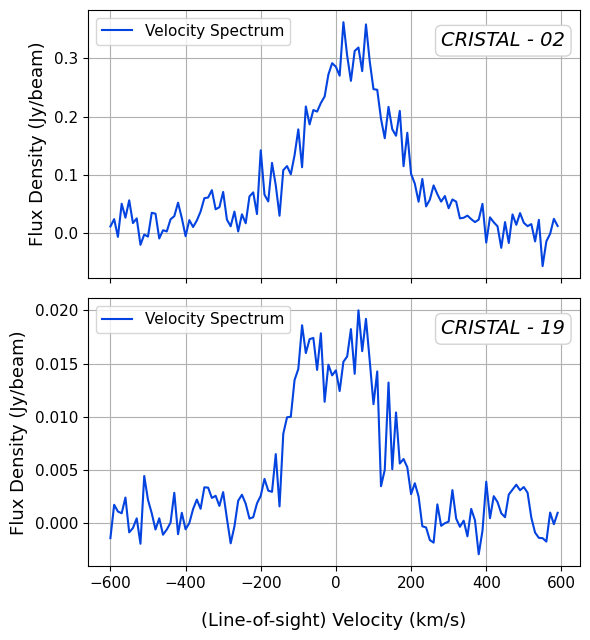

In [ ]:
rest_freq = cube.header['RESTFRQ'] * u.Hz  # For example, if this is in the header
rest_freq2 = cube2.header['RESTFRQ'] * u.Hz  # For example, if this is in the header

# Get the original frequency axis (in Hz)
frequency_axis = cube.spectral_axis
frequency_axis2 = cube2.spectral_axis
# Convert the frequency axis to velocity (km/s)
velocity_axis = frequency_axis.to(u.km / u.s, equivalencies=u.doppler_radio(rest_freq))
velocity_axis2 = frequency_axis2.to(u.km / u.s, equivalencies=u.doppler_radio(rest_freq2))


fig,axes = plt.subplots(2, 1, figsize=(6, 6.5), sharex=True)
mask = create_circular_aperture_mask(data,4,0)
axes[0].plot(velocity_axis[40:160], np.sum(mask*data[:, :, :], axis=(1, 2))[40:160], color = 'xkcd:blue', label = 'Velocity Spectrum')
axes[0].grid()
axes[0].set_ylabel('Flux Density (Jy/beam)', fontsize=13, labelpad=5)
axes[0].legend(fontsize=11)


mask2 = create_circular_aperture_mask(data2,1,0)
axes[1].plot(velocity_axis2[40:160], np.sum(mask2*data2[:, :, :], axis=(1, 2))[40:160], color = 'xkcd:blue', label = 'Velocity Spectrum')
axes[1].grid()
axes[1].set_xlabel('(Line-of-sight) Velocity (km/s)', fontsize=13, labelpad=15)
axes[1].set_ylabel('Flux Density (Jy/beam)', fontsize=13, labelpad=5)
axes[1].legend(fontsize=11)



axes[0].text(
    0.97,  # x near right edge (1.0 is right edge)
    0.85,  # y near bottom edge (0.0 is bottom)
    "CRISTAL - 02",
    color='black',
    fontsize=14,
    ha='right',
    va='bottom',
    style='italic',
    #weight='bold',
    transform=axes[0].transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=1, pad=2, edgecolor='lightgrey')
)

axes[1].text(
    0.97,
    0.85,
    "CRISTAL - 19",
    color='black',
    fontsize=14,
    ha='right',
    va='bottom',
    style='italic',
    #weight='bold',
    transform=axes[1].transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=1, pad=5, edgecolor='lightgrey')
)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=11)  # or any size you prefer


plt.tight_layout()
plt.savefig('figures/cristal_spectrum.pdf', bbox_inches='tight')
plt.show()